### 1: Import Libraries and Define Helper Functions

In [2]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools
from IPython.display import display

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# Helper function to calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI_14'] = 100 - (100 / (1 + rs))
    
    data['20_SMA'] = data['close'].rolling(window=20).mean()
    data['20_std'] = data['close'].rolling(window=20).std()
    data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
    data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)
    
    data['Close_1'] = data['close'].shift(1)
    data['Close_2'] = data['close'].shift(2)
    
    data.dropna(inplace=True)
    return data

### 2: Fetch Data for All Stocks

In [8]:
# stocks = ["AAPL", "ABBV", "ADBE", "AMZN", "AVGO", "BRK-B", "CRM", "COST", "CVX", "HD", 
#           "JNJ", "JPM", "LLY", "MA", "META", "MRK", "MSFT", "NVDA", "PG", "TSLA", "UNH", "V", "XOM"]

stocks = ["AAPL", "ABBV"]
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

stock_data = {}
for stock in stocks:
    data = si.get_data(stock, start_date=start_date, end_date=end_date)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'date'}, inplace=True)
    stock_data[stock] = calculate_technical_indicators(data)
    print(f"Fetched data for {stock}:")
    #display(stock_data[stock])

Fetched data for AAPL:
Fetched data for ABBV:


### 3: Prepare Data for Prophet

In [9]:
def prepare_data_for_prophet(data):
    data_prophet = data[['date', 'close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']].copy()
    data_prophet.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)
    
    data_prophet['SMA_10'] = (data_prophet['SMA_10'] - data_prophet['SMA_10'].mean()) / data_prophet['SMA_10'].std()
    data_prophet['RSI_14'] = (data_prophet['RSI_14'] - data_prophet['RSI_14'].mean()) / data_prophet['RSI_14'].std()
    data_prophet['Upper_Band'] = (data_prophet['Upper_Band'] - data_prophet['Upper_Band'].mean()) / data_prophet['Upper_Band'].std()
    data_prophet['Lower_Band'] = (data_prophet['Lower_Band'] - data_prophet['Lower_Band'].mean()) / data_prophet['Lower_Band'].std()
    data_prophet['Close_1'] = (data_prophet['Close_1'] - data_prophet['Close_1'].mean()) / data_prophet['Close_1'].std()
    data_prophet['Close_2'] = (data_prophet['Close_2'] - data_prophet['Close_2'].mean()) / data_prophet['Close_2'].std()
    
    return data_prophet

prepared_data = {}
for stock, data in stock_data.items():
    prepared_data[stock] = prepare_data_for_prophet(data)
    print(f"Prepared data for Prophet for {stock}:")
    #display(prepared_data[stock])


Prepared data for Prophet for AAPL:
Prepared data for Prophet for ABBV:


### 4: Hyperparameter Tuning

In [13]:
def tune_hyperparameters(train):
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [1.0, 2.0, 3.0, 4.0, 5.0],
    }

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []

    for params in all_params:
        m = Prophet(**params)
        for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
            m.add_regressor(col)
        m.fit(train)
        df_cv = cross_validation(m, initial='365 days', period='1 days', horizon='90 days', parallel="processes")
        df_p = performance_metrics(df_cv)
        rmses.append(df_p['rmse'].mean())

    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    best_params = tuning_results.loc[tuning_results['rmse'].idxmin()]
    return best_params, tuning_results


### 5: Train Separate Prophet Models for Each Stock with Best Parameter Tuning

In [14]:
import joblib

models = {}
forecasts = {}
cv_results_all = {}
best_params_all = {}
tuning_results_all = {}
merged_forecasts_all = {}

for stock, data in prepared_data.items():
    train_size = int(len(data) * 0.8)
    train = data[:train_size]
    test = data[train_size:]
    
    # Tune hyperparameters
    best_params, tuning_results = tune_hyperparameters(train)
    best_params_all[stock] = best_params  # Store best parameters
    tuning_results_all[stock] = tuning_results  # Store tuning results
    tuning_results.to_csv(f"prophet_tuning_results_{stock}.csv", index=False)
    # Display best parameters and tuning results
    print(f"Best parameters for {stock}:")
    display(best_params)
    print(f"Tuning results for {stock}:")
    display(tuning_results)
    
    # Train model with best parameters
    model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                    seasonality_prior_scale=best_params['seasonality_prior_scale'])
    for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
        model.add_regressor(col)
    model.fit(train)
    
    # Save the model
    model_filename = f"{stock}_prophet_model.pkl"
    joblib.dump(model, model_filename)
    print(f"Model for {stock} saved as {model_filename}")
    
    # Cross-validation
    cv_results = cross_validation(model, initial='365 days', period='1 days', horizon='90 days', parallel="processes")
    cv_results_all[stock] = cv_results
    
    # Make predictions
    future = test[['ds']].copy()
    for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
        future[col] = test[col]
    
    forecast = model.predict(future)
    
    models[stock] = model
    forecasts[stock] = forecast
    
    # Merge the forecast with actual values from the test dataset
    merged_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test[['ds', 'y']], on='ds')
    merged_forecasts_all[stock] = merged_forecast
    
    # Print and display merged forecast
    print(f"Trained and forecasted for {stock}:")
    display(merged_forecast)


10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:36 - cmdstanpy - INFO - Chain [1] start processing
10:51:36 - cmdstanpy - INFO - Chain [1] done processing
10:51:55 - cmdstanpy - INFO - Chain [1] start processing
10:51:55 - cmdstanpy - INFO - Chain [1] done processing
10:52:13 - cmdstanpy - INFO - Chain [1] start processing
10:52:13 - cmdstanpy - INFO - Chain [1] done processing
10:52:33 - cmdstanpy - INFO - Chain [1] start processing
10:52:33 - cmdstanpy - INFO - Chain [1] done processing
10:52:55 - cmdstanpy - INFO - Chain [1] start processing
10:52:55 - cmdstanpy - INFO - Chain [1] done processing
10:53:20 - cmdstanpy - INFO - Chain [1] start processing
10:53:20 - cmdstanpy - INFO - Chain [1] done processing
10:53:41 - cmdstanpy - INFO - Chain [1] start processing
10:53:41 - cmdstanpy - INFO - Chain [1]

Best parameters for AAPL:


changepoint_prior_scale    0.050000
seasonality_prior_scale    2.000000
rmse                       2.110129
Name: 6, dtype: float64

Tuning results for AAPL:


,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.01,1.0,2.173855
1,0.01,2.0,2.173865
2,0.01,3.0,2.183746
3,0.01,4.0,2.176516
4,0.01,5.0,2.176320
5,0.05,1.0,2.114877
6,0.05,2.0,2.110129
7,0.05,3.0,2.112048
8,0.05,4.0,2.116583
9,0.05,5.0,2.119596


10:57:54 - cmdstanpy - INFO - Chain [1] start processing
10:57:54 - cmdstanpy - INFO - Chain [1] done processing


Model for AAPL saved as AAPL_prophet_model.pkl
Trained and forecasted for AAPL:


,ds,yhat,yhat_lower,yhat_upper,y
0,2023-09-21,172.764719,169.738206,175.790524,173.929993
1,2023-09-22,171.922826,168.916930,174.674019,174.789993
2,2023-09-25,172.910850,170.036914,176.051845,176.080002
3,2023-09-26,174.209528,171.289435,177.101307,171.960007
4,2023-09-27,172.695778,169.940282,175.671349,170.429993
...,...,...,...,...,...
92,2024-02-02,187.263138,184.049811,190.400595,185.850006
93,2024-02-05,188.663460,185.252287,191.730754,187.679993
94,2024-02-06,191.255340,187.707213,194.151974,189.300003
95,2024-02-07,189.841509,186.263028,192.870580,189.410004


10:58:12 - cmdstanpy - INFO - Chain [1] start processing
10:58:12 - cmdstanpy - INFO - Chain [1] done processing
10:58:30 - cmdstanpy - INFO - Chain [1] start processing
10:58:30 - cmdstanpy - INFO - Chain [1] done processing
10:58:47 - cmdstanpy - INFO - Chain [1] start processing
10:58:47 - cmdstanpy - INFO - Chain [1] done processing
10:59:05 - cmdstanpy - INFO - Chain [1] start processing
10:59:05 - cmdstanpy - INFO - Chain [1] done processing
10:59:23 - cmdstanpy - INFO - Chain [1] start processing
10:59:23 - cmdstanpy - INFO - Chain [1] done processing
10:59:41 - cmdstanpy - INFO - Chain [1] start processing
10:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:00:02 - cmdstanpy - INFO - Chain [1] start processing
11:00:02 - cmdstanpy - INFO - Chain [1] done processing
11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing
11:00:40 - cmdstanpy - INFO - Chain [1] start processing
11:00:40 - cmdstanpy - INFO - Chain [1]

Best parameters for ABBV:


changepoint_prior_scale    0.010000
seasonality_prior_scale    2.000000
rmse                       1.725385
Name: 1, dtype: float64

Tuning results for ABBV:


,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.01,1.0,1.726647
1,0.01,2.0,1.725385
2,0.01,3.0,1.727619
3,0.01,4.0,1.725911
4,0.01,5.0,1.726131
5,0.05,1.0,1.764978
6,0.05,2.0,1.762102
7,0.05,3.0,1.767387
8,0.05,4.0,1.763808
9,0.05,5.0,1.765111


11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] done processing


Model for ABBV saved as ABBV_prophet_model.pkl
Trained and forecasted for ABBV:


,ds,yhat,yhat_lower,yhat_upper,y
0,2023-09-21,154.799072,152.702059,156.836829,153.429993
1,2023-09-22,153.853796,151.836877,155.776249,152.740005
2,2023-09-25,155.766198,153.628109,157.740920,154.649994
3,2023-09-26,156.975760,154.780557,159.026246,153.910004
4,2023-09-27,154.597014,152.549285,156.689877,153.130005
...,...,...,...,...,...
92,2024-02-02,168.859326,166.742459,170.994376,168.669998
93,2024-02-05,170.449363,168.362236,172.475695,171.259995
94,2024-02-06,172.464938,170.434941,174.526496,173.289993
95,2024-02-07,173.619120,171.400821,175.700497,175.009995


### 6: Evaluate the Models

In [15]:
evaluation_results = {}

for stock, merged_forecast in merged_forecasts_all.items():
    y_true = merged_forecast['y'].values
    y_pred = merged_forecast['yhat'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    evaluation_results[stock] = {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}

evaluation_df = pd.DataFrame(evaluation_results).T
display(evaluation_df)

,MAE,RMSE,R²,MAPE
AAPL,1.657345,1.987493,0.943433,0.902093
ABBV,1.354874,1.655648,0.972296,0.903172


### 7: Visualise Results

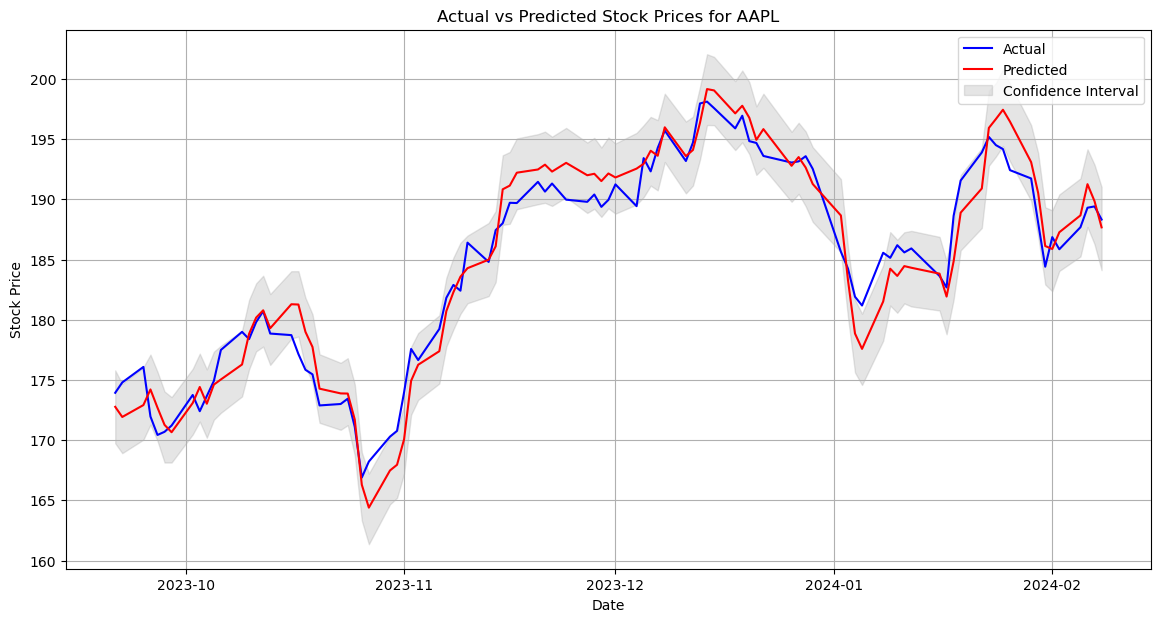

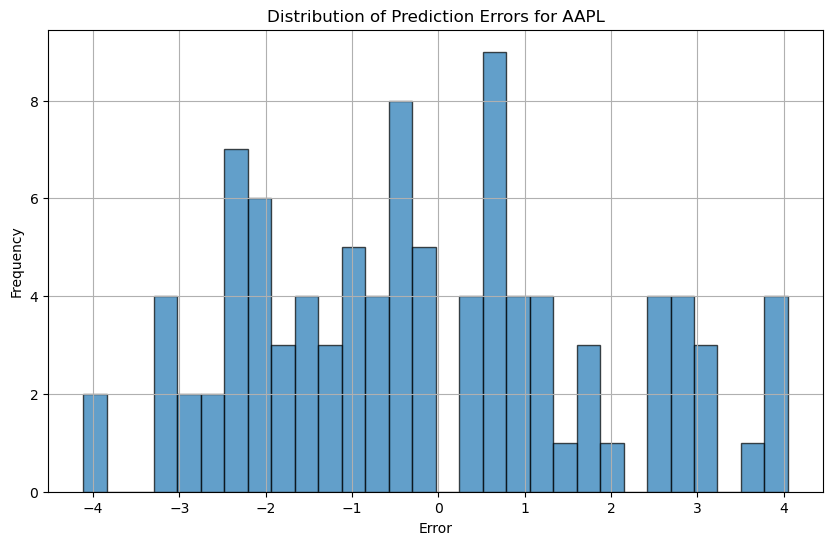

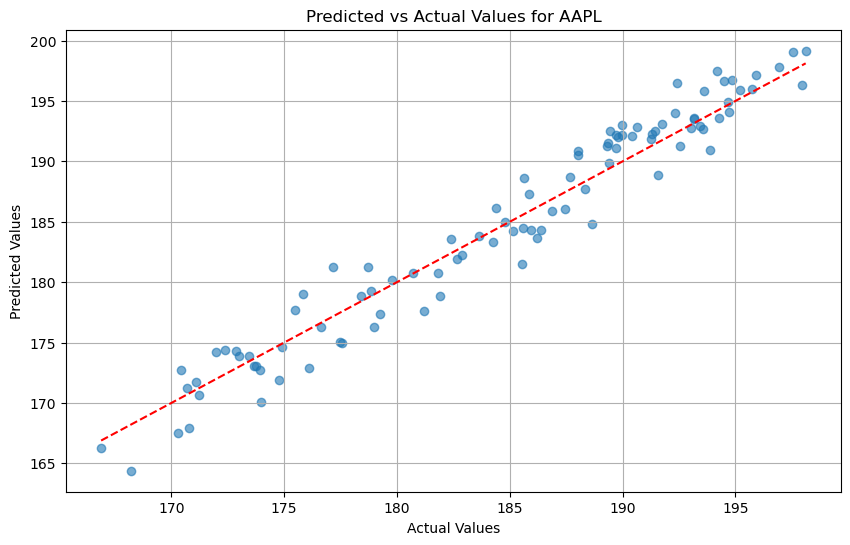

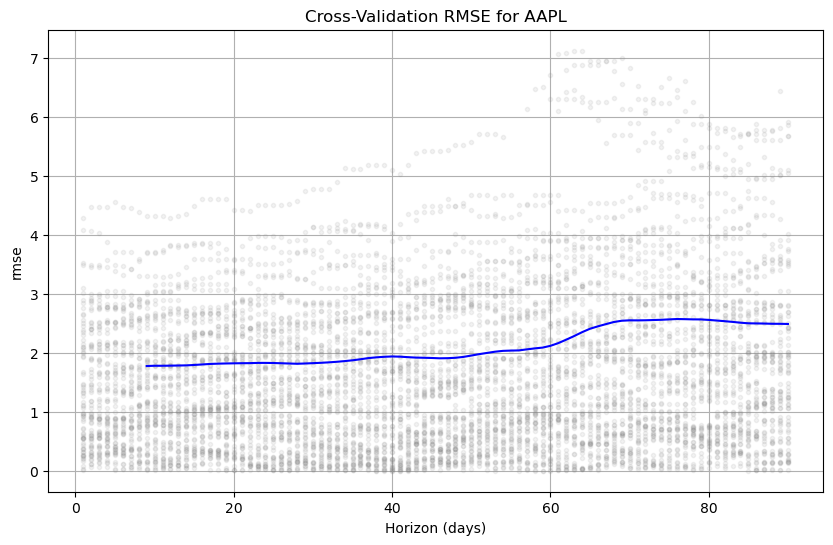

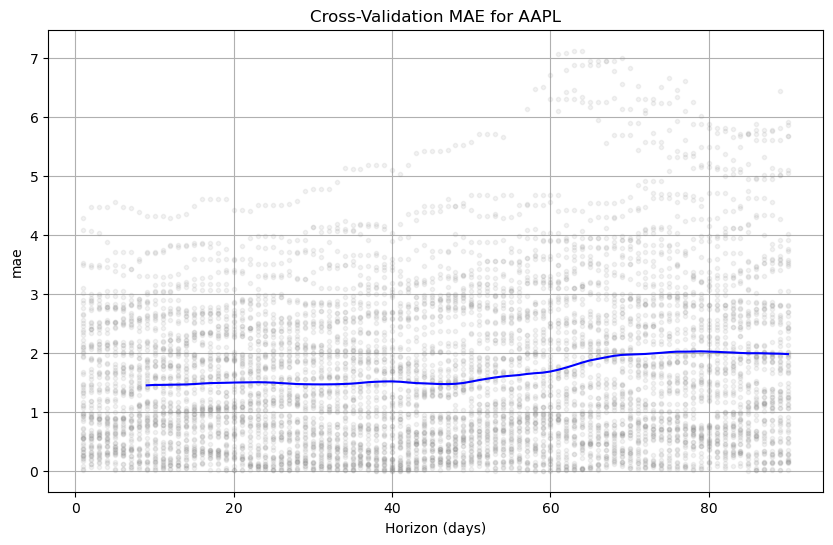

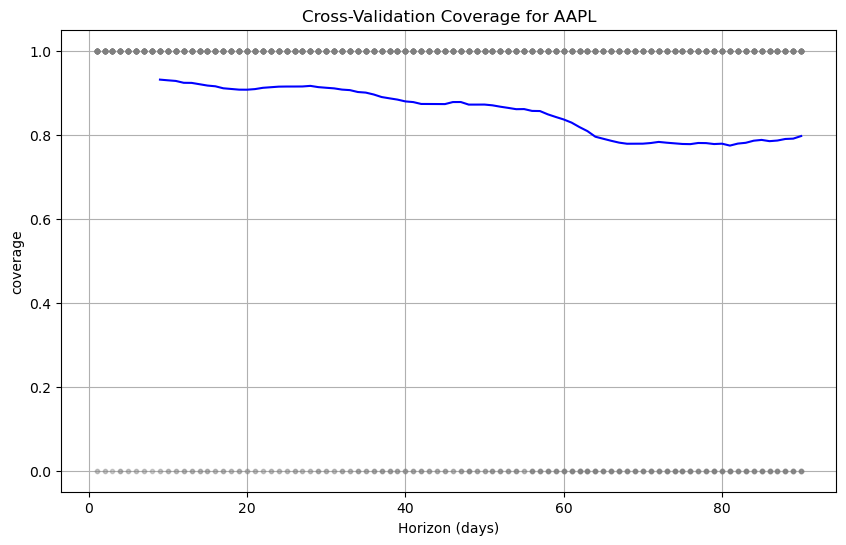

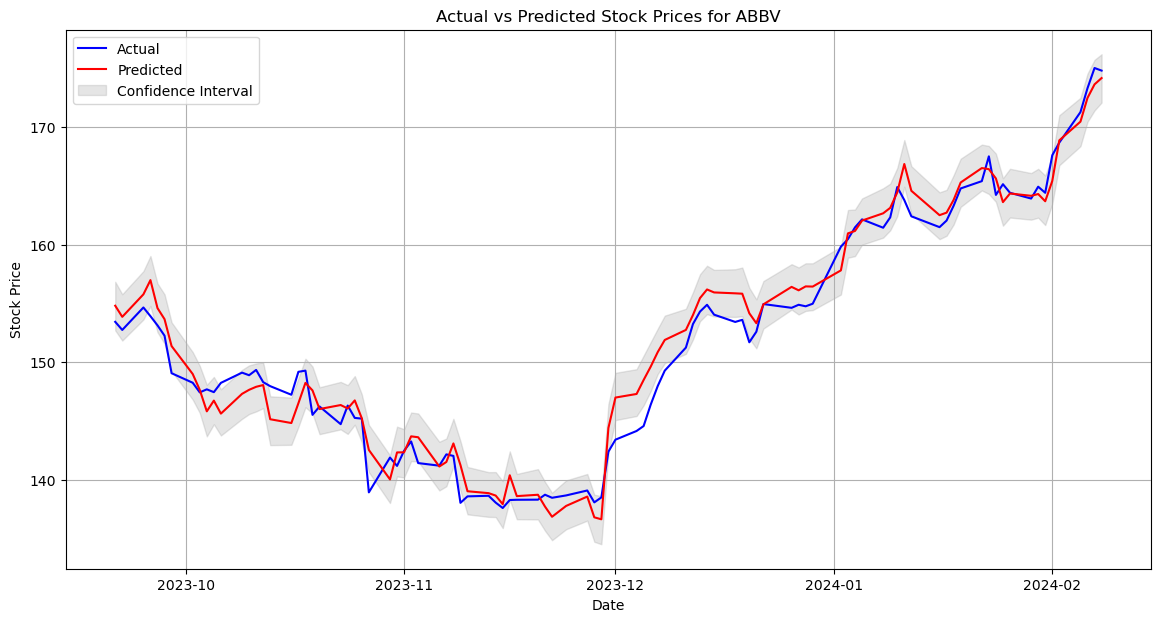

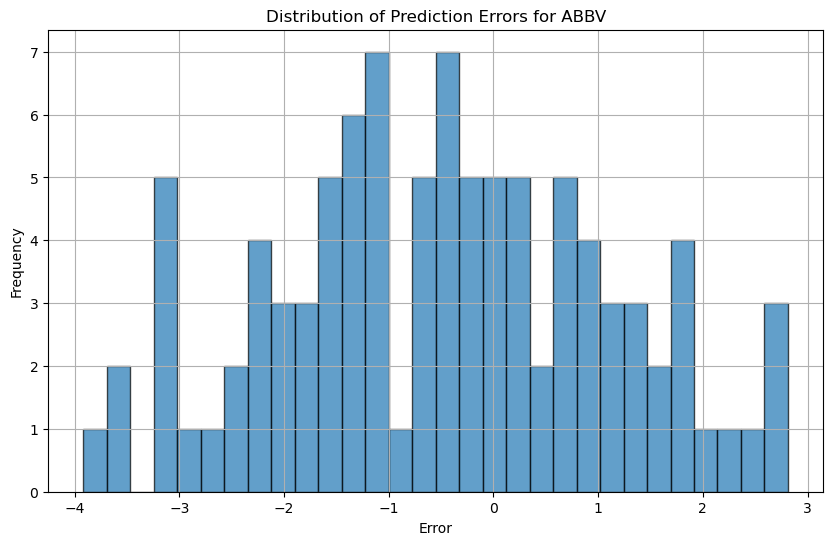

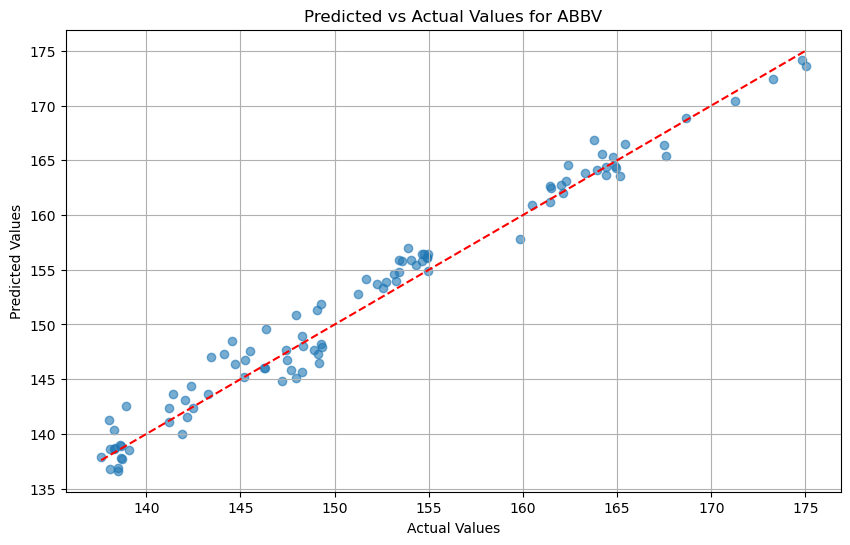

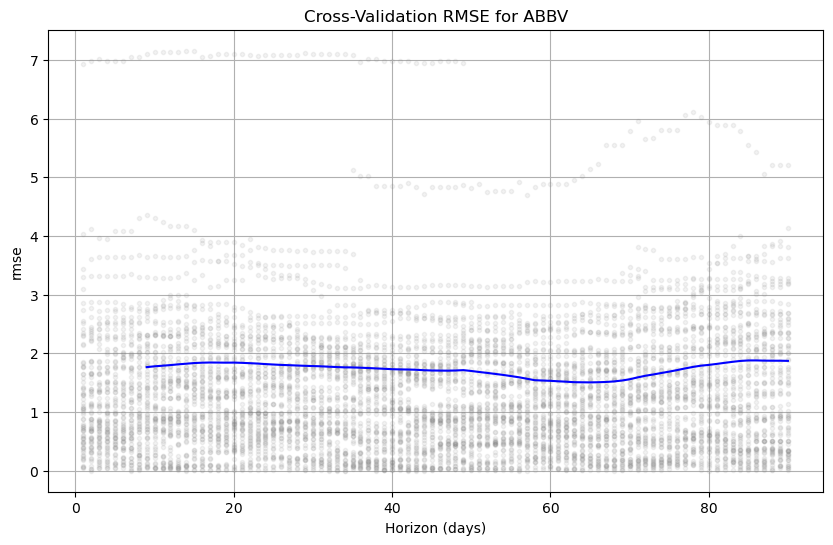

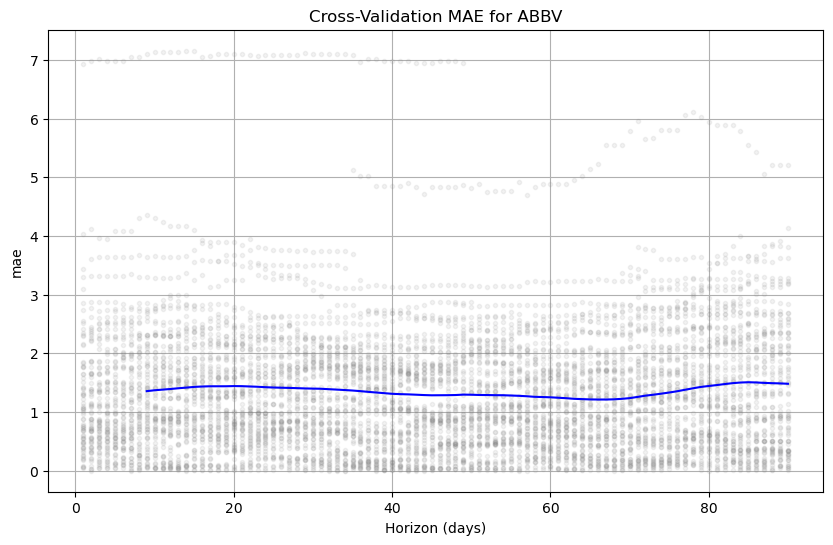

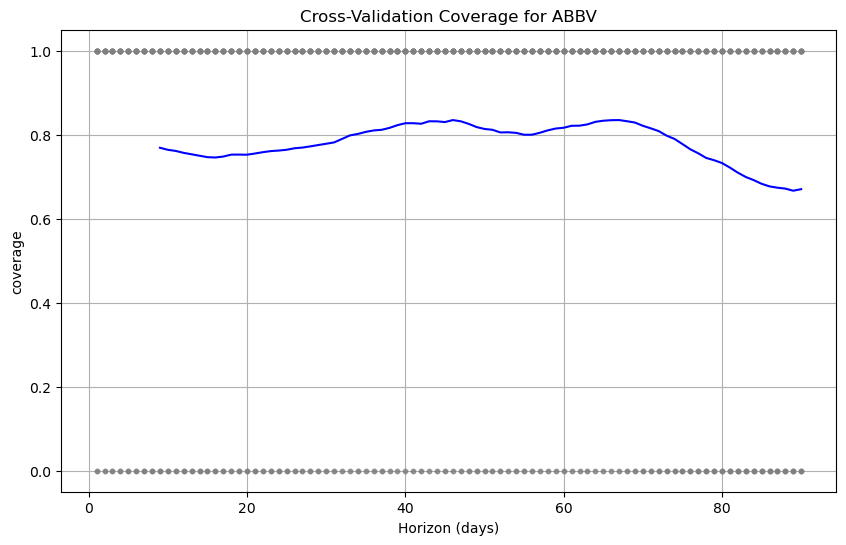

In [16]:
for stock, merged_forecast in merged_forecasts_all.items():
    test = prepared_data[stock][int(len(prepared_data[stock]) * 0.8):]
    
    # Plot forecast vs actual
    plt.figure(figsize=(14, 7))
    plt.plot(test['ds'], test['y'], label='Actual', color='blue')
    plt.plot(test['ds'], merged_forecast['yhat'], label='Predicted', color='red')
    plt.fill_between(test['ds'], merged_forecast['yhat_lower'], merged_forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    plt.title(f'Actual vs Predicted Stock Prices for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot residuals
    residuals = test['y'].values - merged_forecast['yhat'].values
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of Prediction Errors for {stock}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test['y'].values, merged_forecast['yhat'].values, alpha=0.6)
    plt.plot([min(test['y'].values), max(test['y'].values)], [min(test['y'].values), max(test['y'].values)], color='red', linestyle='--')
    plt.title(f'Predicted vs Actual Values for {stock}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

    # Cross-validation metrics
    cv_results = cv_results_all[stock]
    fig = plot_cross_validation_metric(cv_results, metric='rmse')
    plt.title(f'Cross-Validation RMSE for {stock}')
    plt.show()
    
    fig = plot_cross_validation_metric(cv_results, metric='mae')
    plt.title(f'Cross-Validation MAE for {stock}')
    plt.show()
    
    fig = plot_cross_validation_metric(cv_results, metric='coverage')
    plt.title(f'Cross-Validation Coverage for {stock}')
    plt.show()
